<a href="https://colab.research.google.com/github/ulissigroup/Enabling-Robust-Offline-Active-Learning-for-MLPs/blob/master/Figures_3a_c_offline_al.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ase

     |████████████████████████████████| 2.2MB 2.8MB/s 


In [ ]:
import ase.io
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import os
import glob

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
def structure_mae(a, b):
  pos_a = a.positions
  pos_b = b.positions
  return np.mean(np.sum(np.abs(pos_a - pos_b), axis=1))

def energy_mae(a, b):
  energy_a = a.get_potential_energy(apply_constraint=False)
  energy_b = b.get_potential_energy(apply_constraint=False)
  return np.mean(np.abs(energy_a-energy_b))

In [ ]:
parent_traj = ase.io.read("/content/drive/My Drive/CMU - PhD/Research/AMPTorch/Paper/Runs/al relaxation/true_relax_vasp.traj", ":")
relaxed_dft = parent_traj[-1]
delta_ml_dir = "/content/drive/My Drive/CMU - PhD/Research/AMPTorch/Paper/Runs/al relaxation/aug_15_final/final_query/morse_1e-1_0.03_scheduler/"
basename = "paperMorseCopy_1_True_LBFGS_1e-1_random_and_last"

In [ ]:
energy_mae(parent_traj[0], parent_traj[-1])

2.819214340000002

In [ ]:
from collections import defaultdict

trial_results = defaultdict(dict)
for trial in range(10):
  filepath = os.path.join(delta_ml_dir, f"{basename}_{trial}")
  d = defaultdict(dict)
  # iterates through the max number of iterations
  for iter in range(15):
    try:
      traj_path = os.path.join(filepath, f"relax_example_iter_{iter}.traj")
      images = ase.io.read(traj_path, ":")
      d[f"iter_{iter}"] = images
    except:
      continue
  trial_results[f"trial_{trial}"] = d

In [ ]:
trial_energy_errors = []
trial_structure_errors = []
trial_dft_calls = []

for trial in trial_results.keys():
  results = trial_results[trial]
  total_iters = list(results.keys())
  final_iter = total_iters[-1]
  dft_calls = 2*len(total_iters) - 1
  trial_dft_calls.append(dft_calls)


  iter_results = trial_results[trial][final_iter]
  relaxed_image = iter_results[-1]

  structure_loss = structure_mae(relaxed_image, relaxed_dft)
  energy_loss = energy_mae(relaxed_image, relaxed_dft)

  trial_energy_errors.append(energy_loss)
  trial_structure_errors.append(structure_loss)

In [ ]:
print(f"Average energy errors, {np.mean(trial_energy_errors)} eV")
print(f"Average structure errors, {np.mean(trial_structure_errors)} eV/A")
print(f"Average # of DFT calls, {np.mean(trial_dft_calls)}")

Average energy errors, 0.003881121790038833 eV
Average structure errors, 0.0031637377773344895 eV/A
Average # of DFT calls, 16.6


In [ ]:
energy_iters = []
structure_iters = []
energy_errors = []
structure_errors = []
iters = []
errors = []
metric = []
for trial in trial_results:
    for iter in trial_results[trial]:
        iter_count = int(iter.split("_")[1])
        relax_traj = trial_results[trial][iter][-1]
        derror = structure_mae(relax_traj, relaxed_dft)
        iters.append(iter_count*2+1)
        errors.append(derror)
        structure_iters.append(iter_count*2+1)
        structure_errors.append(derror)
        metric.append("Distance ($\AA$)")
        eerror = energy_mae(relax_traj, relaxed_dft)
        iters.append(iter_count*2+1)
        errors.append(eerror)
        energy_iters.append(iter_count*2+1)
        energy_errors.append(eerror)
        metric.append("Energy (eV)")
energy_df = pd.DataFrame.from_dict({"images" : iters, "errors" : errors, "Metric" : metric})

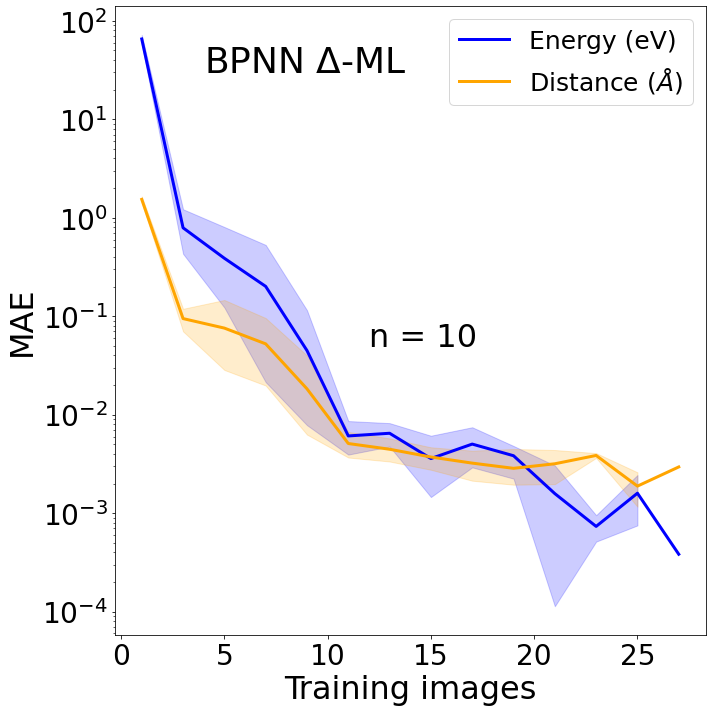

In [ ]:
plt.figure(figsize=(10, 10)) 
ax = sns.lineplot(x=energy_iters, y=energy_errors, lw=3, color="b", ci = 95, label="Energy (eV)")
ax = sns.lineplot(x=structure_iters, y=structure_errors, lw=3, color="orange", ci = 95, label="Distance ($\AA$)")
ax.set(yscale="log")
ax.legend(fontsize=25)
ax.tick_params(labelsize=28)
ax.set_ylabel("MAE", fontsize=32)
ax.text(4, 30, "BPNN $\Delta$-ML", fontsize=36)
ax.text(12, 0.05, "n = 10", fontsize=32)
ax.set_xlabel("Training images", fontsize=32)
plt.tight_layout()
plt.savefig("al_conv.png", dpi=300)
plt.savefig("al_conv.pdf", dpi=300)

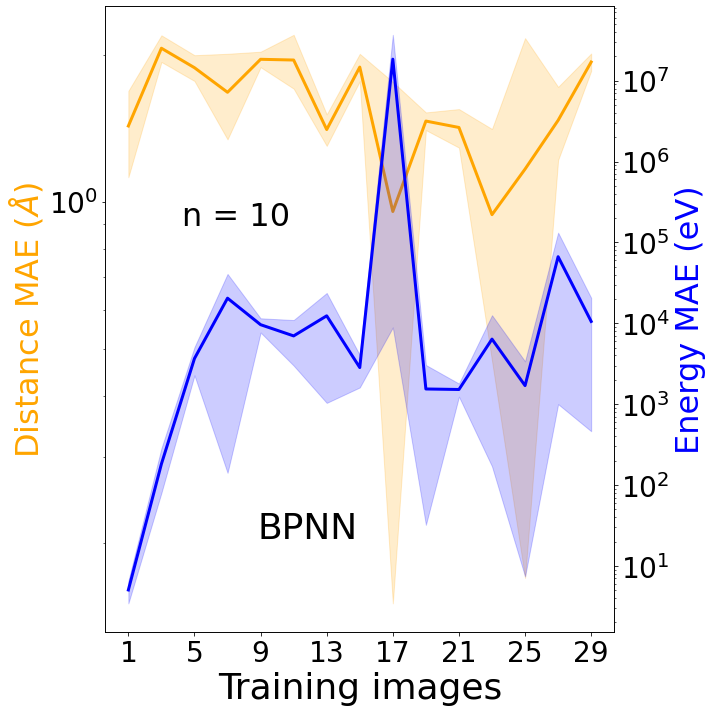

In [ ]:

plt.figure(figsize=(10, 10)) 

ax = sns.lineplot(x=structure_iters, y=structure_errors, lw=3, color="orange", ci = 95)
ax.set(yscale="log")
ax.tick_params(labelsize=28)
ax.set_ylabel("Distance MAE ($\AA$)", fontsize=32, color="orange")
ax.set_xlabel("Training images", fontsize=36)
ax.text(0.3, 0.15, s="BPNN", fontsize=36, transform=ax.transAxes, horizontalalignment="left")
ax.text(0.15, 0.65, s="n = 10", fontsize=32, transform=ax.transAxes, horizontalalignment="left")

ax2 = ax.twinx()
ax = sns.lineplot(x=energy_iters, y=energy_errors, lw=3, color="b", ci = 95)
ax2.set(yscale="log")
ax2.tick_params(labelsize=28)
ax.set_xticks(list(range(1, 30, 4)))
ax2.set_ylabel("Energy MAE (eV)", fontsize=32, color="b")
plt.tight_layout()

plt.savefig("al_conv_mlonly.png", dpi=300)
plt.savefig("al_conv_mlonly.pdf", dpi=300)

#Relaxation plots



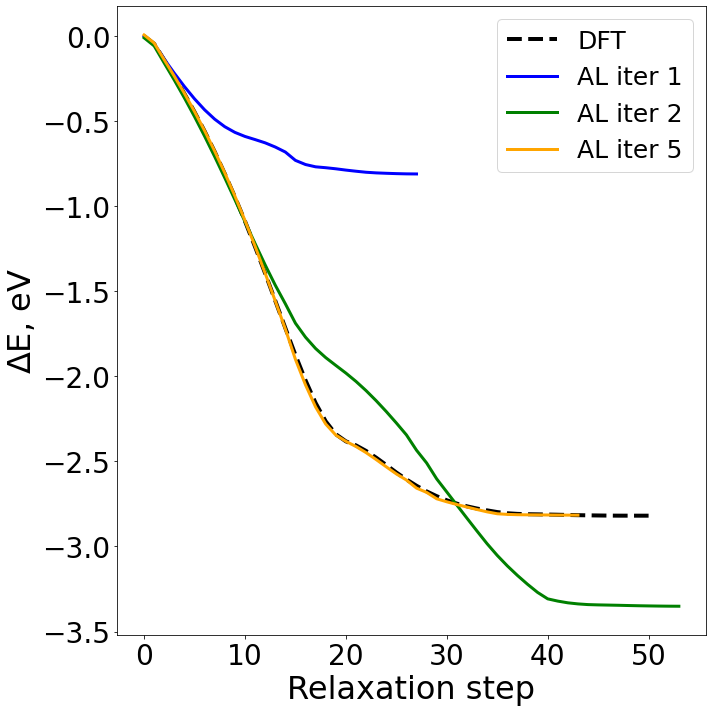

In [ ]:
trial=8

parent_traj = ase.io.read("/content/drive/My Drive/CMU - PhD/Research/AMPTorch/Paper/Runs/al relaxation/true_relax_vasp.traj", ":")
parent_energies = np.array([image.get_potential_energy() for image in parent_traj])
ref_energy = parent_energies[0]
parent_energies -= ref_energy
plt.figure(figsize=(10, 10)) 
plt.plot(range(len(parent_energies)), parent_energies, '--', lw=4, label="DFT", color="black")
colors = ["blue", "green", "orange"]
for i,j in zip([1, 2, 5], colors):
  ml_traj = ase.io.read(f"/content/drive/My Drive/CMU - PhD/Research/AMPTorch/Paper/Runs/al relaxation/aug_15_final/final_query/relax_final_sched_1e-1_0.05/al_relax_final_sched_trial_{trial}/al_relax_scheduler_0.05_iter_{i}.traj", ":")
  ml_energies = np.array([image.get_potential_energy() for image in ml_traj])
  ml_energies -= ref_energy
  plt.plot(range(len(ml_traj)), ml_energies, lw=3, c=j, label=f"AL iter {i}")

for image in parent_traj:
  image.set_cell([0,0,0])
ase.io.write("vasp_slab_initial.png", parent_traj[0], rotation="-75x, 45y, 10z")
ase.io.write("vasp_slab_final.png", parent_traj[-1], rotation="-75x, 45y, 10z")

plt.xlabel("Relaxation step", fontsize=32)
plt.ylabel("$\Delta$E, eV", fontsize=32)
plt.tick_params(labelsize=28)
plt.legend(fontsize=25)
plt.tight_layout()
plt.savefig("al_iterative_relaxation.png", dpi=300)

In [ ]:
ase.io.write("relax_initial.png", ml_traj[0])
ase.io.write("relax_final.png", ml_traj[-1])

###OAL

In [ ]:
parent_traj = ase.io.read("/content/drive/My Drive/CMU - PhD/Research/AMPTorch/Paper/Runs/al relaxation/true_relax_vasp.traj", ":")
relaxed_dft = parent_traj[-1]

In [ ]:
from collections import defaultdict

def num_dft_calls(images, threshold):
  oal_uncertainties = [image.info["uncertainty"][0] for image in images]
  dft_calls = []
  for idx, p in enumerate(oal_uncertainties):
    if p>threshold:
      dft_calls.append(idx)
  return dft_calls

def oal_data(dirname, filename, true_relaxed, threshold):
  all_steps = []
  all_energies = []
  dft_calls = []
  distance_errors = []
  energy_errors = []
  true_energies = [image.get_potential_energy(apply_constraint=False) for image in true_relaxed]
  for i in range(1, 11):
    try:
      oal_path = os.path.join(oal_dir, f"{dirname}_{i}")
      trial = f"{oal_path}/{filename}.traj"
      images = ase.io.read(trial, ":")
      ml_relaxed = images[-1]
      distance_errors.append(structure_mae(ml_relaxed, relaxed_dft))
      energy_errors.append(energy_mae(ml_relaxed, relaxed_dft))
      all_steps += range(len(images))
      dft_calls.append(len(num_dft_calls(images, threshold=threshold)))
    except:
      continue
  return all_steps, all_energies, dft_calls, distance_errors, energy_errors

In [ ]:
oal_dir = "/content/drive/My Drive/CMU - PhD/Research/AMPTorch/Paper/Runs/al relaxation/aug_09_vasp/oal_scheduler/oal_mlonly_scheduler/"
oal_steps, oal_energies, dft_calls, distance_errors, energy_errors = oal_data("oal_trial_scheduler_mlonly", "oal_relax_mlonly_0.05", parent_traj, 0.05)
avg_calls = np.mean(dft_calls)
print(avg_calls)
avg_energy_errors = np.mean(energy_errors)
print(f"Energy errors (MAE): {avg_energy_errors}")
avg_distance_errors = np.mean(distance_errors)
print(f"Distance errors (MAE): {avg_distance_errors}")

22.333333333333332
Energy errors (MAE): 0.28838627714301246
Distance errors (MAE): 0.02630284347997443
